# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- Urvan Christen,
    2- Baptiste Hériard-Dubreuil,
    3- Jean-Baptiste Membrado

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import skimage

DATA_DIR = "project-data/"
IMAGES_DIR = "project-data/images/"
ANNOTATIONS_DIR = "project-data/annotations/"

In [2]:
def get_names(addresses_file):
    """
    Gathers the names of the dataset items contained in the given addresses file.
    Inputs:
        - addresses_file: file containing the names of the dataset items
    Output:
        - list of names of dataset items.
    """
    f = open(addresses_file, "r")
    return [name.strip() for name in f.readlines()]

def get_images(names, dir_path = IMAGES_DIR):
    """
    Gathers the images of the dataset items contained with given names contained in a given directory
    Inputs:
        - names: list of the names of the images to gather.
        - dir_path: directory containing the images.
    Output:
        - {name: image_array} like dictionary of images.
    """
    return {name: skimage.io.imread(dir_path + name + ".jpg") for name in names}

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

def get_annotations(names, dir_path = ANNOTATIONS_DIR):
    """
    Gathers the annotations of the dataset items contained with given names contained in a given directory
    Inputs:
        - names: list of the names of the annotations to gather.
        - dir_path: directory containing the annotations.
    Output:
        - {name: annotations_object} like dictionary of annotations.
    """
    return {name: parse_file(dir_path + name + ".xml") for name in names}

def plot_annotations(ax, annotations):
    """
    Plots the annotaions on the AxesSubplot object.
    Inputs:
        - ax: where to plot the annotaions.
        - annotations: annotations objects to plot.
    Output:
    """
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        
def plot_bboxes(ax, bboxes, **kwargs):
    """
    Plots the annotaions on the AxesSubplot object.
    Inputs:
        - ax: where to plot the annotaions.
        - annotations: annotations objects to plot.
    Output:
    """
    kwargs["linewidth"] = kwargs.setdefault("linewidth", 1)
    kwargs["edgecolor"] = kwargs.setdefault("edgecolor", 'r')
    kwargs["facecolor"] = kwargs.setdefault("facecolor", "none")
    
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                **kwargs)
        ax.add_patch(rect)

def get_mask(img, annotations):
    """
    Gathers the mask of the image marking the annotated bounding boxes.
    Input:
        - img: image to mask (just for the shape)
        - annotations: bounding boxes objects to mark
    Output:
        - binary array of same shape as input image containing True wherever a bounding box is.
    """
    mask = np.zeros(img.shape[:2], "bool")
    for anno in annotations:
        mask[anno['bbox'][1]:anno['bbox'][1] + anno['bbox'][3], anno['bbox'][0]:anno['bbox'][0] + anno['bbox'][2]] = True
    return mask

def get_bboxes(annotations):
    """
    Gathers the annotated bounding boxes.
    Input:
        - annotations: bounding boxes objects to extract
    Output:
        - list of [min_y, min_x, max_y, max_x] bounding boxes (y is the column index)
    """
    return [[anno['bbox'][0], 
             anno['bbox'][1], 
             anno['bbox'][0] + anno['bbox'][2], 
             anno['bbox'][1] + anno['bbox'][3]] for anno in annotations]

def minMaxBbox_to_sizeBbox(minMaxBbox):
    """
    Converts a [x_min, y_min, x_max, y_max] bbox to a [x, y, width, height] bbox.
    """
    return [minMaxBbox[0], minMaxBbox[1], minMaxBbox[2] - minMaxBbox[0], minMaxBbox[3] - minMaxBbox[1]]

def sizeBbox_to_minMaxBbox(sizeBbox):
    """
    Converts a [x, y, width, height] to a bbox [x_min, y_min, x_max, y_max] bbox .
    """
    return [sizeBbox[0], sizeBbox[1], sizeBbox[2] + sizeBbox[0], sizeBbox[3] + sizeBbox[1]]

In [3]:
# Gathers the names of the training dataset items
TRAINING_NAMES = get_names(DATA_DIR + "train.txt")
for name in TRAINING_NAMES[:5]:
    print(name)

5a4a025ca07d567e7d04bed7_32.00px_10
5a90628ea07d569183acf22b_32.00px_5
5984d23b579e529fdea8af09_32.00px_1
5a0de18fa07d56baef59b1f8_32.00px_11
5a3d5aeca07d567e7d04bea8_32.00px_3


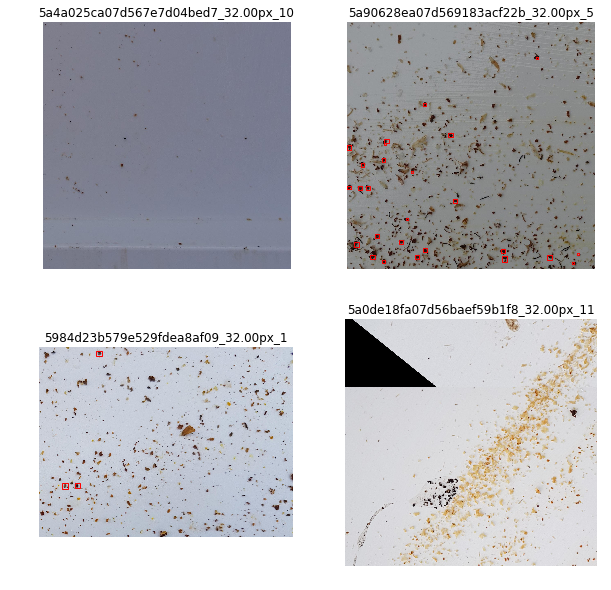

In [4]:
# Gathers some images
TRAINING_IMAGES = get_images(TRAINING_NAMES[:12], IMAGES_DIR + "train/")
TRAINING_ANNOTATIONS = get_annotations(TRAINING_NAMES[:12], ANNOTATIONS_DIR + "train/")

(nrows, ncols) = (2, 2)

# Plots the images and annotations
fig, ax = plt.subplots(nrows, ncols, figsize = (5 * ncols, 5 * nrows))
k = 0
for i in range(nrows):
    for j in range(ncols):
        name = TRAINING_NAMES[k]
        ax[i, j].imshow(TRAINING_IMAGES[name])
        plot_annotations(ax[i, j], TRAINING_ANNOTATIONS[name])
        ax[i, j].axis('off')
        ax[i, j].set_title(name)
        k += 1
plt.show()

## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [5]:
def show_histogram(img, mask, channel=0):
    """
    Shows histogram of input image on given channel
    Input: 
        - img: image to analyze
        - mask: binary array of same shape as img containing the positions of positive class pixels
        - channel: (int) channel (RGB) to consider
    Output: 
        - shows the histogram of pixels for positive and negative pixels.
    """
    pixels_mask = img[:, :, channel][ mask]
    pixels_comp = img[:, :, channel][~mask]
    
    plt.hist(pixels_mask, density=True, bins=100, alpha=0.5)
    plt.hist(pixels_comp, density=True, bins=100, alpha=0.5)
    
    plt.show()
    
def show_histogram2d(img, mask, channels=(0, 1)):
    """
    Shows 2D-histogram of input image on given channels
    Input: 
        - img: image to analyze
        - mask: binary array of same shape as img containing the positions of positive class pixels
        - channels: (int, int) channels (RGB) to consider
    Output: 
        - shows the 2D-histogram of pixels for positive and negative pixels.
    """
    pixels_mask0 = img[:, :, channels[0]][ mask]
    pixels_comp0 = img[:, :, channels[0]][~mask]
    
    pixels_mask1 = img[:, :, channels[1]][ mask]
    pixels_comp1 = img[:, :, channels[1]][~mask]
    
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    ax[0].hist2d(pixels_mask0, pixels_mask1, bins=100)
    ax[1].hist2d(pixels_comp0, pixels_comp1, bins=100)
    
    plt.show()

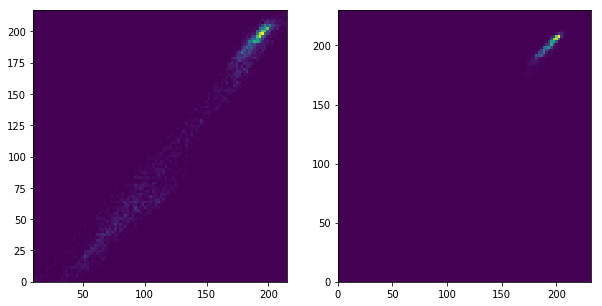

In [6]:
name = TRAINING_NAMES[2]
img = TRAINING_IMAGES[name]
annotations = TRAINING_ANNOTATIONS[name]
mask = get_mask(img, annotations)
show_histogram2d(img, mask, (0, 1))

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage.io
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.morphology import closing, square
from skimage.measure import regionprops
from skimage.color import label2rgb


import cv2 as cv

# We based this implementation on what we did in Lab 1 for varroae detection

def detect_by_segmentation(image):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    
    label_image = label_by_segmentation(image)
    list_boxes = create_boxes(image, label_image)
    return [minMaxBbox_to_sizeBbox(bbox) for bbox in list_boxes]

def label_by_segmentation(image):
    '''
    Input: One single image
    Output: One single image containing labelled zones where potential varroas are located
    '''
    # apply threshold
    gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    blur = cv.blur(gray_image,(3,3))
    
    # _, thresh = cv.threshold(blur,100,255,cv.THRESH_BINARY_INV + cv.THRESH_OTSU)    
    thresh = cv.adaptiveThreshold(gray_image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 9, 3.5)

    bw = closing(thresh > 0.5, square(2))

    # remove artifacts connected to image border
    cleared = bw.copy()
    clear_border(cleared)

    # label image regions
    label_image = label(cleared)
    
    return label_image

In [8]:
def create_boxes(image, label_image):
    """
    Creates boxes containing varroas location based on labeled image. Removes those too small or too large.
    Input: 
        - image: image to analyze
        - label_image: labeled positions of potential varroas
    Output: 
        - list of bounding boxes (min max) of potential varroas
    """
    list_boxes = []
    
    image_label_overlay = label2rgb(label_image, image=image)
    
    for region in regionprops(label_image):
        # skip the too small or too big boxes
        if region.area > 250 and region.area < 1000 and region.major_axis_length < 50:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            list_boxes.append([minc, minr, maxc, maxr])

    return list_boxes

In [9]:
def get_overlap_bbox(bboxA, bboxB):
    """
    Compute the overlap area between two bounding boxes
    Input: 
        - bboxA: bounding box (min max)
        - bboxB: bounding box (min max)
    Output: 
        - area of overlap
    """
    return max(0, min(bboxA[2], bboxB[2]) - max(bboxA[0], bboxB[0])) *\
        max(0, min(bboxA[3], bboxB[3]) - max(bboxA[1], bboxB[1]))

def get_overlap_bboxes(bboxes_A, bboxes_B):
    """
    Compute pairwise overlap area between two bounding boxes
    Input: 
        - bboxes_A: bounding box list (min max)
        - bboxes_B: bounding box list (min max)
    Output: 
        - 2D-array containing areas of overlap: overlap[i, j] contains overlap between bboxes_A[i] and bboxes_B[j]
    """
    return np.array([[get_overlap_bbox(bbA, bbB) for bbB in bboxes_B] for bbA in bboxes_A])

def get_area_bbox(bbox):
    """
    Compute the area of a bounding box
    Input: 
        - bbox: bounding box (min max)
    Output: 
        - area of bounding box
    """
    return (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])

def get_IoU_bboxes(bboxes_A, bboxes_B):
    """
    Compute pairwise IoU area between two bounding boxes. IoU is defined as the ratio between overlap area and union area
    Input: 
        - bboxes_A: bounding box list (min max)
        - bboxes_B: bounding box list (min max)
    Output: 
        - 2D-array containing areas of IoU: IoU[i, j] contains IoU between bboxes_A[i] and bboxes_B[j]
    """
    areasA = [get_area_bbox(bbA) for bbA in bboxes_A]
    areasB = [get_area_bbox(bbB) for bbB in bboxes_B]
    
    # Compute (AiB)/(AuB) as (AiB)/(A + B - AiB) where i is the intersection and u the union
    return np.array([[get_overlap_bbox(bbA, bbB) / (areaA + areaB - get_overlap_bbox(bbA, bbB)) \
             for (bbB, areaB) in zip(bboxes_B, areasB)]\
            for (bbA, areaA) in zip(bboxes_A, areasA)])

def get_IoU_ref_score(bboxes_ref, bboxes_obs):
    """
    Compute IoU area of the best observed bbox for each reference bounding box.
    Input: 
        - bboxes_ref: reference bounding box list (min max)
        - bboxes_obs: observed  bounding box list (min max)
    Output: 
        - array containing the best IoU score for each reference bbox.
    """
    IoU = get_IoU_bboxes(bboxes_ref, bboxes_obs)
    if IoU.size == 0: return np.zeros(len(bboxes_ref))
    return np.max(IoU, axis=1)

def get_IoU_obs_score(bboxes_ref, bboxes_obs):
    """
    Compute IoU area of the best reference bbox for each observed bounding box.
    Input: 
        - bboxes_ref: reference bounding box list (min max)
        - bboxes_obs: observed  bounding box list (min max)
    Output: 
        - array containing the best IoU score for each observed bbox.
    """
    IoU = get_IoU_bboxes(bboxes_ref, bboxes_obs)
    if IoU.size == 0: return np.zeros(len(bboxes_obs))
    return np.max(IoU, axis=0)

def get_confusion_matrix(bboxes_ref, bboxes_obs, th=0.3):
    """
    Compute the confusion matrix based on reference and observed bounding boxes.
    Input: 
        - bboxes_ref: reference bounding box list (min max)
        - bboxes_obs: observed  bounding box list (min max)
    Output: 
        - confusion matrix. 
        [tp, fn]
        [fp, tn]
    """
    IoU = get_IoU_bboxes(bboxes_ref, bboxes_obs)
    if IoU.size == 0: obs_score = np.zeros(len(bboxes_obs))
    else: obs_score = np.max(IoU, axis=0)
        
    if IoU.size == 0: ref_score = np.zeros(len(bboxes_ref))
    else: ref_score = np.max(IoU, axis=1)
    tp = np.sum(ref_score > th)
    return np.array([[tp, len(ref_score) - tp], [len(obs_score) - tp, 0]])

def get_precision(bboxes_ref, bboxes_obs, th=0.3):
    """
    Compute the precision score based on reference and observed bounding boxes.
    Input: 
        - bboxes_ref: reference bounding box list (min max)
        - bboxes_obs: observed  bounding box list (min max)
    Output: 
        - precision score (tp / (tp + fp))
    """
    cm = get_confusion_matrix(bboxes_ref, bboxes_obs, th=0.3)
    return (cm[0, 0] / (cm[0, 0] + cm[1, 0]))
            
            
def get_recall(bboxes_ref, bboxes_obs, th=0.3):
    """
    Compute the recall score based on reference and observed bounding boxes.
    Input: 
        - bboxes_ref: reference bounding box list (min max)
        - bboxes_obs: observed  bounding box list (min max)
    Output: 
        - recall score (tp / (tp + fn))
    """
    cm = get_confusion_matrix(bboxes_ref, bboxes_obs, th=0.3)
    return (cm[0, 0] / (cm[0, 0] + cm[0, 1]))


def get_F1(bboxes_ref, bboxes_obs, th=0.3):
    """
    Compute the F1 score based on reference and observed bounding boxes.
    Input: 
        - bboxes_ref: reference bounding box list (min max)
        - bboxes_obs: observed  bounding box list (min max)
    Output: 
        - F1 score (tp / (tp + fn))
    """
    precision = get_precision(bboxes_ref, bboxes_obs, th=0.3)
    recall = get_recall(bboxes_ref, bboxes_obs, th=0.3)
    return 2 * precision * recall / (precision + recall)

/Users/Darcane/anaconda3/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/Users/Darcane/anaconda3/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


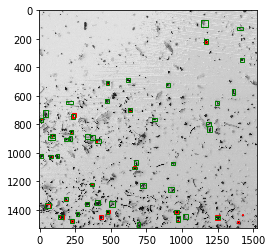

Name of the image 5a90628ea07d569183acf22b_32.00px_5
Number of detected boxes 49
Number of true boxes 26

IoU scores
[0.71680217 0.53829787 0.54855643 0.75136612 0.77284946 0.82142857
 0.70872483 0.         0.61621622 0.6747449  0.29331046 0.17496635
 0.56603774 0.64559819 0.         0.67514677 0.36363636 0.14824561
 0.63362069 0.18567639 0.         0.64748201 0.15335753 0.68196721
 0.59090909 0.46758767]


In [10]:
def plot_detection(img_name):
    '''
    Plots the result of our segmentation algorithm on the given image 
    Input:
        - img_name: the name of the image to test in the TRAINING_IMAGES array
    Output: no output, this function plots and displays information
    '''
    
    image = TRAINING_IMAGES[img_name]

    img_gray = skimage.color.rgb2gray(image)
    output = label_by_segmentation(image)

    list_boxes = create_boxes(img_gray, output)
    expected_boxes = get_bboxes(TRAINING_ANNOTATIONS[img_name])

    fig, ax = plt.subplots(1, 1)
    
    ax.imshow(img_gray,cmap="gray")
    plot_annotations(ax, TRAINING_ANNOTATIONS[img_name])
    plot_bboxes(ax, list_boxes, edgecolor="g")
    plt.show()

    print("Name of the image", img_name)
    
    print('Number of detected boxes', len(list_boxes))
    print('Number of true boxes', len(expected_boxes))

    print()
    print("IoU scores")
    print(get_IoU_ref_score(expected_boxes, list_boxes))

img_name = '5a90628ea07d569183acf22b_32.00px_5' 
plot_detection(img_name)

In [11]:
# Compute the precision and recall scores for several images.
for name in TRAINING_NAMES[:12]:
    test_img = TRAINING_IMAGES[name]

    img_gray = cv.cvtColor(test_img, cv.COLOR_RGB2GRAY)
    output = label_by_segmentation(test_img)

    list_boxes = create_boxes(img_gray, output)
    expected_boxes = get_bboxes(TRAINING_ANNOTATIONS[name])
    
    print("Image: {}   Precision: {:.3f}   Recall: {:.3f}   F1: {:.3f}".format(name,
                                                           get_precision(expected_boxes, list_boxes),
                                                           get_recall(expected_boxes, list_boxes),
                                                           get_F1(expected_boxes, list_boxes)))

/Users/Darcane/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in long_scalars
/Users/Darcane/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in long_scalars


Image: 5a4a025ca07d567e7d04bed7_32.00px_10   Precision: nan   Recall: nan   F1: nan
Image: 5a90628ea07d569183acf22b_32.00px_5   Precision: 0.367   Recall: 0.692   F1: 0.480
Image: 5984d23b579e529fdea8af09_32.00px_1   Precision: 0.053   Recall: 1.000   F1: 0.100
Image: 5a0de18fa07d56baef59b1f8_32.00px_11   Precision: 0.000   Recall: nan   F1: nan
Image: 5a3d5aeca07d567e7d04bea8_32.00px_3   Precision: 0.204   Recall: 0.719   F1: 0.317


/Users/Darcane/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in double_scalars


Image: 59a31cbaa07d5673ec099c8b_32.00px_7   Precision: 0.000   Recall: 0.000   F1: nan
Image: 5ad21210a07d5605be933dc4_32.00px_0   Precision: 0.000   Recall: nan   F1: nan
Image: 5a19d440a07d5643ecfab27c_32.00px_0   Precision: nan   Recall: nan   F1: nan
Image: 59f01b6fa07d563535ffc6d2_32.00px_1   Precision: 0.047   Recall: 0.625   F1: 0.088
Image: 5a147495a07d56baef59b20d_32.00px_13   Precision: 0.000   Recall: nan   F1: nan
Image: 5a3674f8a07d567f57e0273a_32.00px_2   Precision: 0.000   Recall: nan   F1: nan
Image: 59d678cca07d5605c2118821_32.00px_0   Precision: 0.034   Recall: 1.000   F1: 0.066


Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

We'll test our implementation on some of the training images provided

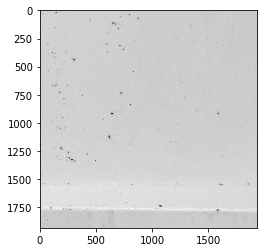

Name of the image 5a4a025ca07d567e7d04bed7_32.00px_10
Number of detected boxes 0
Number of true boxes 0

IoU scores
[]


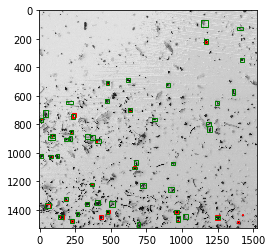

Name of the image 5a90628ea07d569183acf22b_32.00px_5
Number of detected boxes 49
Number of true boxes 26

IoU scores
[0.71680217 0.53829787 0.54855643 0.75136612 0.77284946 0.82142857
 0.70872483 0.         0.61621622 0.6747449  0.29331046 0.17496635
 0.56603774 0.64559819 0.         0.67514677 0.36363636 0.14824561
 0.63362069 0.18567639 0.         0.64748201 0.15335753 0.68196721
 0.59090909 0.46758767]


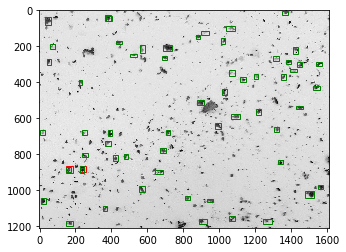

Name of the image 5984d23b579e529fdea8af09_32.00px_1
Number of detected boxes 57
Number of true boxes 3

IoU scores
[0.54380665 0.52330827 0.45759369]


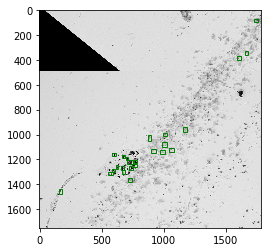

Name of the image 5a0de18fa07d56baef59b1f8_32.00px_11
Number of detected boxes 24
Number of true boxes 0

IoU scores
[]


In [12]:
# Gathers some images
# Change this variable to test the detection for several images
nmbr_img = 4

TRAINING_IMAGES = get_images(TRAINING_NAMES[:nmbr_img], IMAGES_DIR + "train/")
TRAINING_ANNOTATIONS = get_annotations(TRAINING_NAMES[:nmbr_img], ANNOTATIONS_DIR + "train/")

for k in range(nmbr_img):
        name = TRAINING_NAMES[k]
        plot_detection(name)

plt.show()

In [13]:
TRAINING_ANNOTATIONS['5a0de18fa07d56baef59b1f8_32.00px_11']

[]

Du coup je suis allé zoom sur les images en les ouvrant dans le dossier, et c'est un peu dur à voir mais effectivement, dans la 4ème image, y a pas de mite. Dans la 3 j'en vois 4 perso mais bon je suis pas expert mite non plus.
En revanche y en a beaucoup dans la 2 en effet.

## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

First we will try to use Fourier descriptors as in Lab 2.

In [14]:
def contour(image):
    '''
    This function gives the contour of grayscale image.
    Input:
        - image: grayscale 8U1C image. In our case, it is a window of a bigger image.
    Output:
        - closed: the positions of the points of the contour
        - ctr: the contour in an OpenCV form
    '''
    
    _, thresh = cv.threshold(image,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    closed = closing(thresh, square(3))
    ctr = find_contours(closed, 128)
    return closed, ctr

In [15]:
import numpy as np
from scipy import signal

def fourier_descriptor(contour, inv_trans=True, inv_rot=True, inv_scal=True, ctr_len=50):
    '''
    This function extracts the fourier descriptors from the input contour.
    Input:
        - contour: the contour of the image
        - inv_trans: True if we want the descriptors to be invariant to translation
        - inv_rot: True if we want the descriptors to be invariant to rotation
        - inv_scal: True if we want the descriptors to be invariant to scaling
        - ctr_len: the length of the input contour. If the length of the contour is different from
            ctr_len, we resample the contour to be of length ctr_len
    Output:
        - f_ctr: the Fourier descriptors of the contour
    '''
    ctr = contour[:,0] + 1j*contour[:,1]
        
    ctr_resampled = signal.resample(ctr, ctr_len)
    
    f_ctr = np.fft.fft(ctr_resampled)
        
    if inv_scal:
        f_ctr = f_ctr / np.abs(f_ctr[0])
    
    if inv_trans:
        f_ctr[0] = 0
        
    if inv_rot:
        f_ctr = np.abs(f_ctr)
        
    return f_ctr

The basic idea is to use the first Fourier descriptor of each window during the sliding window process. We can typically use the two first descriptors.

We also may use Principal Component Analysis on the Fourier descriptors in order to have better features for classification with the sliding windows.

In [16]:
def sliding_window(image, step_size, window_size):
    '''
    This function creates a set of sliding windows of fixed sizes.
    Input:
        - image: grayscale image to slide windows on
        - step_size: the size of the steps of each jump of the window
        - window_size: the size of the window to analyze
    Output:
        - a generator of all the windows produced by sliding windows
    '''
    y_len, x_len = image.shape
    
    for y in range(0, y_len, step_size):
        for x in range(0, x_len, step_size):
            yield(x, y, image[y:y + window_size[1], x:x + window_size[0]])

In [17]:
img_name = '5a90628ea07d569183acf22b_32.00px_5' 
image = TRAINING_IMAGES[img_name]
gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

gen_windows = sliding_window(gray_image, 10, (50, 50))
for idx, window in enumerate(gen_windows):
    if idx % 10000 == 0:
        print(window)

(0, 0, array([[151, 151, 151, ..., 152, 152, 152],
       [151, 151, 151, ..., 152, 152, 152],
       [152, 151, 151, ..., 152, 152, 152],
       ...,
       [151, 151, 151, ..., 155, 154, 151],
       [151, 151, 150, ..., 152, 153, 153],
       [151, 151, 151, ..., 152, 154, 154]], dtype=uint8))
(550, 650, array([[142, 142, 141, ...,  74,  71,  68],
       [148, 148, 147, ...,  79,  75,  68],
       [149, 149, 147, ...,  82,  76,  62],
       ...,
       [144, 145, 146, ...,  80,  93, 109],
       [145, 145, 145, ...,  81,  90, 101],
       [143, 143, 145, ...,  80,  85,  97]], dtype=uint8))
(1100, 1300, array([[113, 121, 121, ..., 123, 126, 130],
       [125, 126, 126, ..., 125, 127, 132],
       [130, 131, 126, ..., 127, 129, 132],
       ...,
       [130, 132, 132, ..., 114, 110, 107],
       [133, 133, 131, ..., 118, 114, 109],
       [131, 130, 131, ..., 116, 115, 116]], dtype=uint8))


In [22]:
def sliding_window_with_scaling(image, scaling_factor, nb_layers):
    
    window_size = image.shape
    step_size = image.shape[0]
    
    for k in range(nb_layers):
        yield(sliding_window(image, step_size, window_size))
        
        step_size = step_size/scaling_factor
        window_size = (window_size[0]/scaling_factor, window_size[1]/scaling_factor)

In [24]:
img_name = '5a90628ea07d569183acf22b_32.00px_5' 
image = TRAINING_IMAGES[img_name]
gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

gen_layers = sliding_window_with_scaling(gray_image, 2, 10)

for layer in gen_layers:
    for idx, window in enumerate(layer):
        if idx % 10000 == 0:
            print(window)

(0, 0, array([[151, 151, 151, ..., 155, 156, 157],
       [151, 151, 151, ..., 151, 152, 152],
       [152, 151, 151, ..., 142, 143, 144],
       ...,
       [125, 126, 128, ..., 106, 106, 111],
       [134, 133, 134, ..., 110, 111, 112],
       [129, 129, 133, ..., 120, 118, 118]], dtype=uint8))


TypeError: 'float' object cannot be interpreted as an integer

In [19]:
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    
    

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [15]:
#Your code

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [16]:
#Your code

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [17]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [18]:
#Your code